In [2]:
%config ZMQInteractiveShell.ast_node_interactivity='all'

In [69]:
from PIL import Image
import numpy as np
import argparse
import imageio
import dnnlib
import dnnlib.tflib as tflib
import os
import pickle
from tqdm import tqdm
import PIL.Image
import moviepy.editor

In [4]:
tflib.init_tf()
with open('./networks/normal_face.pkl', "rb") as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


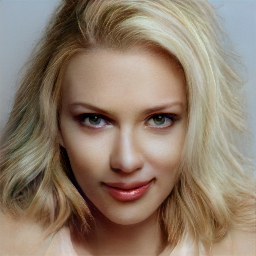

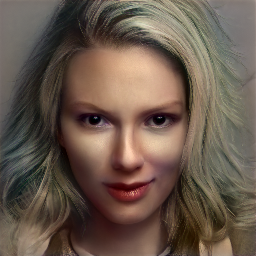

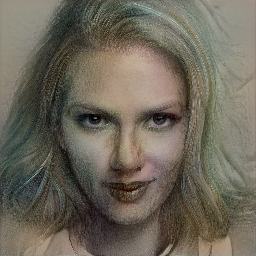

In [15]:
pic1 = np.load('./latent_representations/sjl.npy')
pic2 = np.load('./latent_style/tianshi.npy')
pic3 = np.load('./latent_style/sumiao3.npy')

img1 = Gs_network.components.synthesis.run(pic1[np.newaxis, :], **Gs_syn_kwargs)
img1 = Image.fromarray(img1[0])
img1.resize((256,256))
pic1[9:] = pic2[9:]
img2 = Gs_network.components.synthesis.run(pic1[np.newaxis, :], **Gs_syn_kwargs)
img2 = Image.fromarray(img2[0])
img2.resize((256,256))
pic1[9:] = pic3[9:]
img2 = Gs_network.components.synthesis.run(pic1[np.newaxis, :], **Gs_syn_kwargs)
img2 = Image.fromarray(img2[0])
img2.resize((256,256))

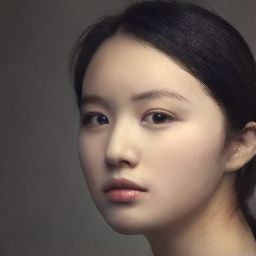

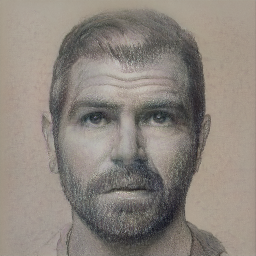

In [11]:
Image.fromarray(Gs_network.components.synthesis.run(pic2[np.newaxis, :], **Gs_syn_kwargs)[0]).resize((256,256))
Image.fromarray(Gs_network.components.synthesis.run(pic3[np.newaxis, :], **Gs_syn_kwargs)[0]).resize((256,256))

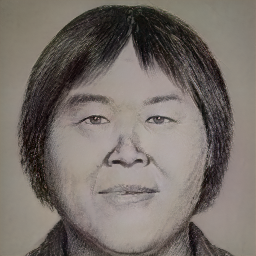

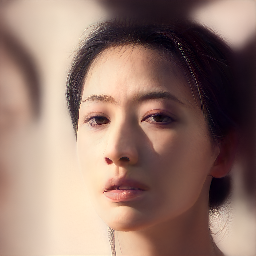

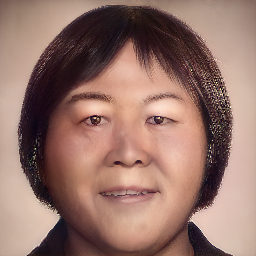

In [79]:
style = np.load('./latent_style/beauty13.npy')
src = np.load('./latent_style/meiyi1.npy')
img1 = Image.fromarray(Gs_network.components.synthesis.run(src[np.newaxis, :], **Gs_syn_kwargs)[0]).resize((256,256))
img2 = Image.fromarray(Gs_network.components.synthesis.run(style[np.newaxis, :], **Gs_syn_kwargs)[0]).resize((256,256))
src[9:] = style[9:]
img = Gs_network.components.synthesis.run(src[np.newaxis, :], **Gs_syn_kwargs)
img = Image.fromarray(img[0])
img1
img2
img.resize((256,256))

beauty3 tianshi star beauty9 beauty12 beauty13 beauty8 random1 3 4 5 6 random2

In [96]:
def render_video(src_file, dst_dir, tmp_dir, num_frames, mode, size, fps, codec, bitrate):

    def render_frame(t):
        frame = np.clip(np.ceil(t * fps), 1, num_frames)
        image = PIL.Image.open('%s/%04d.png' % (tmp_dir, frame))
        if mode == 1:
            canvas = image
        else:
            canvas = PIL.Image.new('RGB', (2 * src_size, src_size))
            canvas.paste(src_image, (0, 0))
            canvas.paste(image, (src_size, 0))
        if size != src_size:
            canvas = canvas.resize((mode * size, size), PIL.Image.LANCZOS)
        return np.array(canvas)

    src_image = PIL.Image.open(src_file)
    src_size = src_image.size[1]
    duration = num_frames / fps
    filename = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.mp4')
    video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
    video_clip.write_videofile(filename, fps=fps, codec=codec, bitrate=bitrate)

In [81]:
def style_transform(pic1, pic2, dst_dir, epoch):
    pic = pic1.copy()
    scale = [x / 125 for x in range(0, 126)]
    for i, w in tqdm(enumerate(scale)):
        pic[9:] = pic1[9:]*(1-w)+pic2[9:]*w
        img = Gs_network.components.synthesis.run(pic[np.newaxis, :], **Gs_syn_kwargs)
        img = PIL.Image.fromarray(img[0])
        img.save('{}/{}{}.png'.format(dst_dir, epoch, str(i).zfill(4)))
    return pic

In [93]:
def rename(file):
    imgs_book = sorted(os.listdir('./output/meiyi'), key = lambda x: int(x[:-4]))
    for i,img in enumerate(imgs_book):
        os.rename('{}{}'.format(file, img), '{}{}.png'.format(file, str(i).zfill(4)))
    print ('done')

In [83]:
src_npy = './latent_style/meiyi1.npy'
npy_book = ['beauty3', 'tianshi', 'star', 'beauty9', 'beauty12', 'beauty13', 
            'beauty8','random1', '3', '4', '5', '6', 'random2', 'meiyi1']
pic1 = np.load(src_npy)
epoch = 0
for style in npy_book:
    pic2 = np.load('./latent_style/{}.npy'.format(style))
    pic1 = style_transform(pic1, pic2, './output/meiyi', epoch)
    epoch += 1

126it [01:08,  1.84it/s]
126it [01:11,  1.76it/s]
126it [01:11,  1.77it/s]
126it [01:11,  1.76it/s]
126it [01:08,  1.84it/s]
126it [01:07,  1.87it/s]
126it [01:06,  1.90it/s]
126it [01:08,  1.84it/s]
126it [01:18,  1.60it/s]
126it [01:16,  1.65it/s]
126it [01:16,  1.66it/s]
126it [01:16,  1.65it/s]
126it [01:18,  1.61it/s]
126it [01:08,  1.83it/s]


In [95]:
rename('./output/meiyi/')

done


In [97]:
render_video('./generated_images/meiyi1.png', './output', './output/meiyi', 1764, 2, 1024, 25,
            'libx264', '5M')

t:   0%|          | 3/1764 [00:00<00:59, 29.61it/s, now=None]

Moviepy - Building video ./output/meiyi1.mp4.
Moviepy - Writing video ./output/meiyi1.mp4




t:  20%|█▉        | 349/1764 [00:17<01:05, 21.75it/s, now=None]


t:  40%|███▉      | 700/1764 [00:34<00:47, 22.50it/s, now=None]


t:  59%|█████▉    | 1045/1764 [00:51<00:38, 18.62it/s, now=None]


t:  75%|███████▌  | 1329/1764 [01:05<00:21, 19.79it/s, now=None]


t:  93%|█████████▎| 1636/1764 [01:21<00:06, 19.59it/s, now=None]


t:   7%|▋         | 127/1764 [16:17<01:24, 19.39it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output/meiyi1.mp4
